## Plot mutation prediction results

In this notebook, we'll compare the results of our mutation prediction experiments for expression and methylation data only (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)
* PLOT_AUROC (bool): if True plot AUROC, else plot AUPR

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

In [2]:
# set results directory
merged_geneset = True

if merged_geneset:
    results_dir = Path(cfg.results_dirs['mutation'],
                       'merged_methylation',
                       'gene').resolve()
    # if True, save figures to ./images directory
    # set this to False for cosmic genes, for now
    SAVE_FIGS = False
else:
    results_dir = Path(cfg.results_dirs['mutation'],
                       'methylation_results_shuffle_cancer_type',
                       'gene').resolve()
    # currently we're using the vogelstein figures for the paper
    SAVE_FIGS = True

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['mutation'], 'auroc')
else:
    plot_metric = 'aupr'
    images_dir = Path(cfg.images_dirs['mutation'])

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression'])].copy()

print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(13032, 9)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99962,0.99578,MAP3K1,expression,signal,42,train,0,gene
1,0.61241,0.17782,MAP3K1,expression,signal,42,test,0,gene
2,0.68779,0.24224,MAP3K1,expression,signal,42,cv,0,gene
3,0.98210,0.87136,MAP3K1,expression,signal,42,train,1,gene
4,0.74268,0.37469,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene',
                                                              old_filenames=True)
compressed_results_df = compressed_results_df[
    (compressed_results_df.training_data.isin(['me_27k', 'me_450k'])) &
    (compressed_results_df.n_dims == 5000)
].copy()
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
print(compressed_results_df.shape)
compressed_results_df.head()

[ 1 42]
['me_450k' 'me_27k']
[5000]
(26064, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.60644,0.17261,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.62170,0.24357,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.58918,0.23904,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}
results_df.training_data.replace(to_replace=training_data_map, inplace=True)
results_df.head()

[42  1]
['expression' 'me_450k' 'me_27k']
['raw' 5000]
(39096, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.99962,0.99578,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.61241,0.17782,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.68779,0.24224,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.98210,0.87136,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.74268,0.37469,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = au.compare_all_data_types(results_df,
                                           SIG_ALPHA,
                                           metric=plot_metric)

cfg.sig_genes_dir.mkdir(exist_ok=True)
all_results_df.to_csv(cfg.sig_genes_methylation, index=False, sep='\t')

all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
44,CDH1,0.267396,3.139193e-10,4.496580e-08,True,27k methylation,7.347118
223,RB1,0.226690,3.306309e-10,4.496580e-08,True,27k methylation,7.347118
50,CDKN2A,0.240568,1.668281e-09,4.537724e-07,True,450k methylation,6.343162
40,CCND1,0.596570,1.783364e-09,2.491186e-07,True,gene expression,6.603594
258,TP53,0.233481,2.691327e-09,2.491186e-07,True,gene expression,6.603594
122,IKZF3,0.643132,2.747632e-09,2.491186e-07,True,gene expression,6.603594
258,TP53,0.236573,3.948071e-09,5.369376e-07,True,450k methylation,6.270076
50,CDKN2A,0.260997,6.619475e-09,4.501243e-07,True,gene expression,6.346668
122,IKZF3,0.366313,7.323505e-09,6.639978e-07,True,450k methylation,6.177833
210,PTEN,0.355148,1.450323e-08,7.165000e-07,True,gene expression,6.144784


gene expression: 113/272
27k methylation: 62/272
450k methylation: 77/272


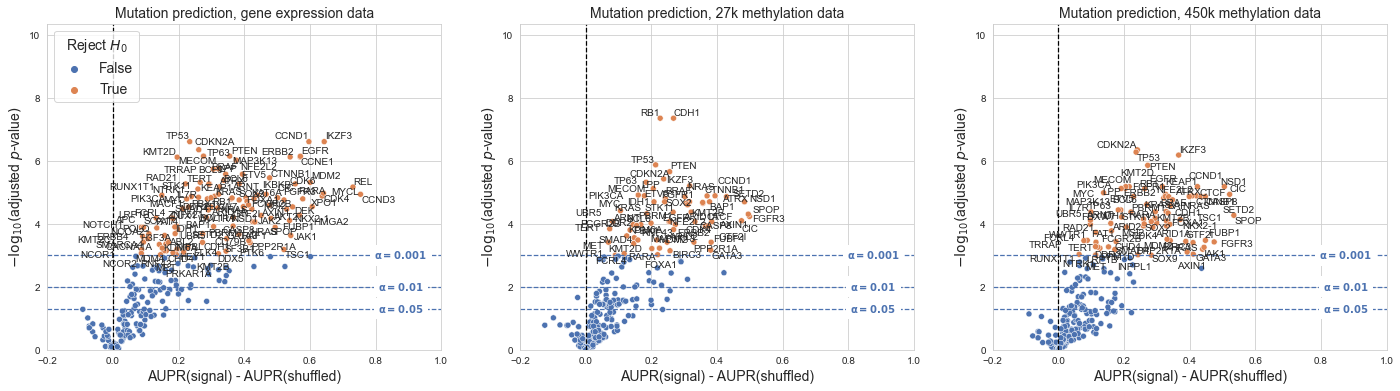

In [7]:
sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          training_data_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True)
    
if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

In [8]:
# map gene/training data combinations to accept/reject null
# vs. shuffled baseline
# we want to plot this info on top of -omics comparison
id_to_sig = (all_results_df
  .loc[:, ['gene', 'training_data', 'reject_null']]
  .rename(columns={'reject_null': 'reject_null_baseline'})
)

id_to_sig.head()

,gene,training_data,reject_null_baseline
0,ABL1,gene expression,False
1,ABL2,gene expression,True
2,ACVR2A,gene expression,False
3,AFF3,gene expression,False
4,AFF4,gene expression,False


27k methylation: 42/272
450k methylation: 37/272


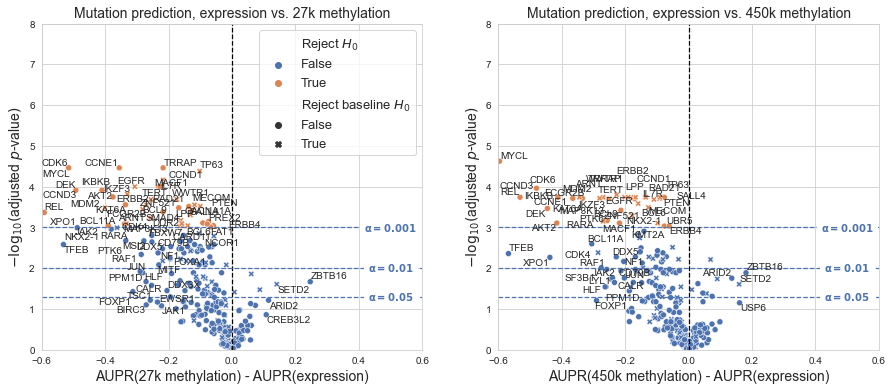

In [9]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (15, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)


plu.plot_volcano_comparison(results_df,
                            axarr,
                            training_data_map,
                            SIG_ALPHA,
                            metric=plot_metric,
                            xlim=(-0.6, 0.6),
                            sig_genes=id_to_sig,
                            verbose=True)

if SAVE_FIGS:
    plt.savefig(images_dir / 'methylation_comparison.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_comparison.png',
                dpi=300, bbox_inches='tight')

(121,)
['ABL2' 'AKT2' 'APC' 'ARID1A' 'ARNT' 'ATRX' 'AXIN1' 'BAP1' 'BCL11A' 'BCL6'
 'BCL9' 'BRAF' 'CACNA1A' 'CASP8' 'CCND1' 'CCND3' 'CCNE1' 'CD79B' 'CDH1'
 'CDK4' 'CDK6' 'CDKN2A' 'CHD4' 'CIC' 'CTNNB1' 'CUX1' 'DDR2' 'DDX5' 'DEK'
 'EGFR' 'ELK4' 'ERBB2' 'ERBB4' 'ETV5' 'FAT4' 'FBXW7' 'FCGR2B' 'FCRL4'
 'FGFR3' 'FOXA1' 'FUBP1' 'GATA3' 'GTF2I' 'H3F3A' 'HEY1' 'HMGA2' 'HRAS'
 'IDH1' 'IKBKB' 'IKZF3' 'IL7R' 'JAK1' 'JAK2' 'KAT6A' 'KDM6A' 'KEAP1'
 'KMT2B' 'KMT2C' 'KMT2D' 'KRAS' 'LPP' 'LRP1B' 'MACF1' 'MAP3K13' 'MDM2'
 'MDM4' 'MECOM' 'MET' 'MSI2' 'MYC' 'MYCL' 'NCOA2' 'NCOR1' 'NCOR2' 'NFE2L2'
 'NIPBL' 'NKX2-1' 'NOTCH1' 'NRAS' 'NSD1' 'NTRK1' 'PBRM1' 'PBX1' 'PIK3CA'
 'POLQ' 'PPP2R1A' 'PRKAR1A' 'PTEN' 'PTK6' 'RAD21' 'RAF1' 'RARA' 'RB1'
 'REL' 'RNF43' 'RUNX1T1' 'SETD2' 'SF3B1' 'SMAD4' 'SMARCA4' 'SOX17' 'SOX2'
 'SPOP' 'STK11' 'TERT' 'TP53' 'TP63' 'TRRAP' 'TSC1' 'UBR5' 'WWTR1' 'XPO1'
 'ZNF521' 'ARID2' 'BIRC3' 'CTCF' 'FAT1' 'FGFR1' 'INPPL1' 'PPM1D' 'SOX9']


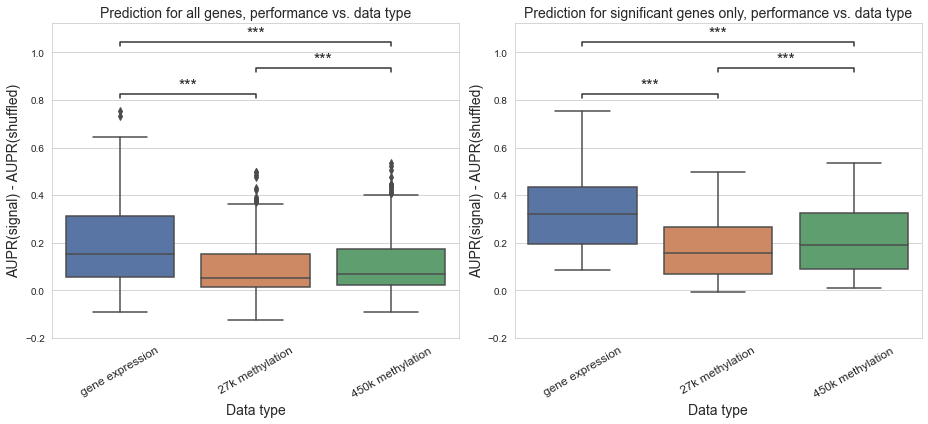

In [10]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

tests_df = plu.plot_boxes(all_results_df,
                          axarr,
                          training_data_map,
                          metric=plot_metric,
                          verbose=True,
                          pairwise_tests=True,
                          pairwise_box_pairs=[('gene expression', '27k methylation'),
                                              ('27k methylation', '450k methylation'),
                                              ('gene expression', '450k methylation')])

if SAVE_FIGS:
    plt.savefig(images_dir / 'methylation_best_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_best_boxes.png',
                dpi=300, bbox_inches='tight')

In [11]:
# pairwise rank sum tests comparing results distributions
# H0: results distributions are the same between the data types
tests_df.sort_values(['gene_set', 'p_value'])

,data_type_1,data_type_2,p_value,corr_pval,reject_null,gene_set
0,gene expression,27k methylation,3.216687e-29,9.650062e-29,True,all
1,gene expression,450k methylation,1.423248e-22,4.269745e-22,True,all
2,27k methylation,450k methylation,8.138330e-12,2.441499e-11,True,all
0,gene expression,27k methylation,2.052649e-18,6.157948e-18,True,significant
1,gene expression,450k methylation,4.279379e-15,1.283814e-14,True,significant
2,27k methylation,450k methylation,1.572544e-13,4.717632e-13,True,significant


In [12]:
heatmap_df = (all_results_df
    .pivot(index='training_data', columns='gene', values='delta_mean')
    .reindex(training_data_map.values())
)
heatmap_df.iloc[:, :5]

gene,ABL1,ABL2,ACVR2A,AFF3,AFF4
training_data,,,,,
gene expression,-0.023133,0.165843,0.189751,0.063795,-0.030470
27k methylation,0.000121,0.051285,0.077563,-0.002089,0.012968
450k methylation,-0.002683,0.049527,0.113294,0.023516,-0.029826


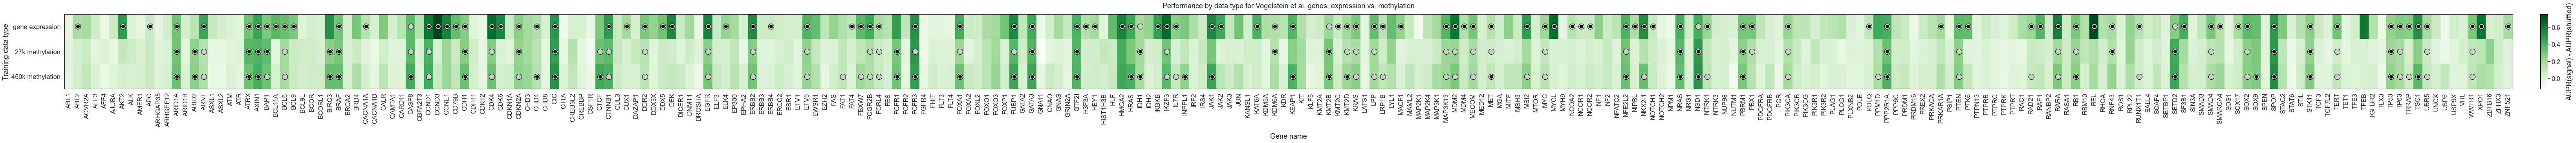

In [13]:
sns.set({'figure.figsize': (100, 5)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(heatmap_df,
                      all_results_df.reset_index(drop=True),
                      results_df,
                      metric=plot_metric,
                      origin_eps_x=0.02,
                      origin_eps_y=0.015,
                      length_x=0.85,
                      length_y=0.95)

plt.title('Performance by data type for Vogelstein et al. genes, expression vs. methylation', pad=15)

if SAVE_FIGS:
    plt.savefig(images_dir / 'methylation_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_heatmap.png',
                dpi=300, bbox_inches='tight')

Key to above heatmap:

* A grey dot = significantly better than label-permuted baseline, but significantly worse than best-performing data type
* A grey dot with black dot inside = significantly better than label-permuted baseline, and not significantly different from best-performing data type (i.e. "statistically equivalent to best")
* No dot = not significantly better than label-permuted baseline